## 앙상블 분류기와 다양한 범위의 분류기를 가진 경우와 비교하기 위해 확률 질량함수 구현

In [1]:
from scipy.special import comb
import math
def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) * error ** k * (1-error)**(n_classifier - k) for k in range(k_start,n_classifier + 1)]

    return sum(probs)
ensemble_error(n_classifier=11, error = 0.25)

0.03432750701904297

In [2]:
### 분류기 에러가 0.0에서 1.0까지 걸쳐 있을 때, 앙상블의 에러율 계산 및 시각화

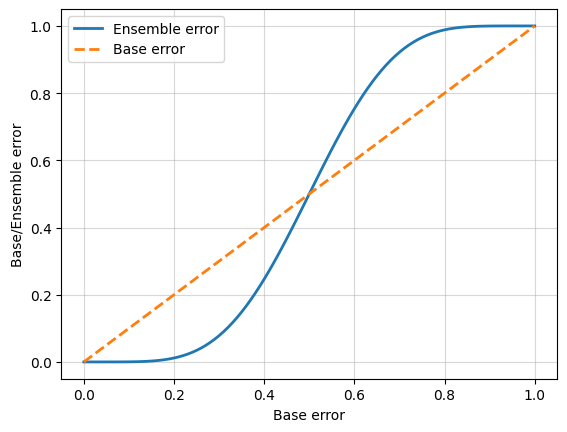

In [3]:
import numpy as np
import matplotlib.pyplot as plt

error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) for error in error_range]
plt.plot(error_range, ens_errors, label = 'Ensemble error', linewidth=2)
plt.plot(error_range, error_range, linestyle='--', label='Base error', linewidth=2)

plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

##### 이 앙상블 분류기는 sklearn.ensemble.VotingClassifier로 사이킷런 0.17 이후버전으로 사용될 수 있습니다

# Combining classifiers via majority vote

In [4]:
# Implementing a simple majority vote classifier

import numpy as np
np.argmax(np.bincount([3, 0, 1], weights = [0.2, 0.2, 0.6]))

1

In [5]:
# 아래 무슨 상황인지 이해 안감
ex=np.array([[0.9,0.1], [0.8, 0.2], [0.4,0.6]])

p=np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])

In [6]:
p

array([0.58, 0.42])

# MajortyVoteClassifier를 사용하여 향상시키기

In [7]:
# !pip install -U sklearn

In [8]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {
            key: value for key,
            value in _name_estimators(classifiers)
        }
        self.vote = vote
        self.weights = weights


    def fit(self, X, y):
        if self.vote not in ('proability', 'classlabel'):
            raise ValueError(f"vote must be 'probaility'"
                             f"or 'classlabel'"
                             f"; get (vote={self.vote})")
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f'Number of classifiers and'
                             f' weights must be equeal'
                             f'; get{len(self.weights)} classifiers')
        # User LabelEncoder to ensure class labels start
        # with 0, which is important for np.argmax
        # call in self.predict

        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_=self.lablenc_.classes_
        self.classifiers_=[]
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X,self.lablenc_.transform(y))

            self.classifiers_.append(fitted_clf)
        return self


    # 어떤 용도의 함수이죠?
    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis = 1)
        else: # 'classlabel' vote
            #collect result from clf.predcit calls
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                lambda x: np.argmax(
                    np.bincount(x, weights=self.weights)
                ),
                axis=1, arr=predictions
            )
            maj_vote = self.lablenc_.inverse_transform(maj_vote)
            return maj_vote


    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)

        return avg_proba


    def get_params(self, deep=True):
        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep).items():
                    out[f'{name}__{key}'] = value

            return out


In [9]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()
X,y = iris.data[50:, [1,2]], iris.target[50:]
le = LabelEncoder()
y= le.fit_transform(y)

In [10]:
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.5, random_state=1, stratify=y)

# Using the train dataset, we now will train three different classifiers:
- Logistic regression clasifier
- Decision tree classifer
- k-nearest neighbors classifier

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2', C=0.001, solver='lbfgs', random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])

pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train,y=y_train, cv=10, scoring='roc_auc')

    print(f'ROC AUC: {scores.mean(): .2f}'
         f'(+/-{scores.std():.2f}) [{label}]')


10-fold cross validation:

ROC AUC:  0.92(+/-0.15) [Logistic regression]
ROC AUC:  0.87(+/-0.18) [Decision tree]
ROC AUC:  0.85(+/-0.13) [KNN]


In [12]:
mv_clf = MajorityVoteClassifier(
    classifiers = [pipe1, clf2, pipe3]
)
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10, #뭐 의미?
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f}'
          f'(+/- {scores.std():.2f})[{label}]')


ROC AUC: 0.92(+/- 0.15)[Logistic regression]
ROC AUC: 0.87(+/- 0.18)[Decision tree]
ROC AUC: 0.85(+/- 0.13)[KNN]
ROC AUC: 0.98(+/- 0.05)[Majority voting]


# Evaluating and tuning the ensemble classifier (이 코드 이해 잘 안됌)

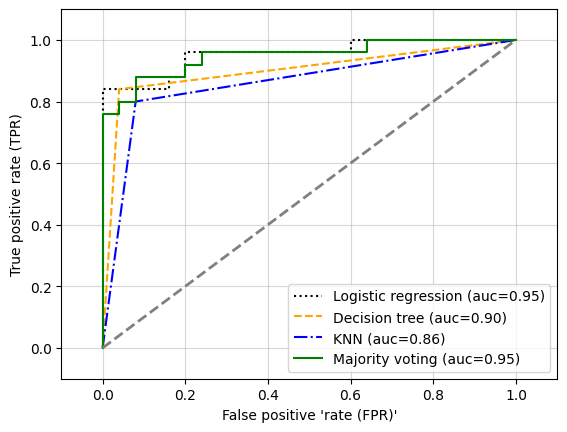

In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles =[':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)

    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label=f'{label} (auc={roc_auc:.2f})')

plt.legend(loc='lower right')
plt.plot([0,1], [0,1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel("False positive 'rate (FPR)'")
plt.ylabel("True positive rate (TPR)")
plt.show()


In [14]:
all_clf

[Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc', StandardScaler()),
                                                     ['clf',
                                                      LogisticRegression(C=0.001,
                                                                         random_state=1)]]),
                                     DecisionTreeClassifier(criterion='entropy',
                                                            max_depth=1,
                                                            random_state=0),
                                     Pipeline(steps=[('sc', StandardScaler()),
                                                     ['clf',
               

## 개별분류모델과 보팅모델의 분류 결과 시각화

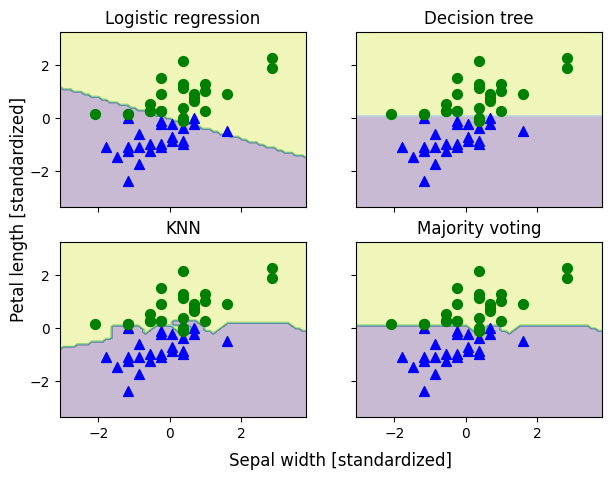

In [15]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train) # 따로 추가함

from itertools import product
# all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1 # 왜 1을 빼주고 더해주는 것일까?
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(7,5))

for idx, clf, tt in zip(product([0,1], [0,1]),
                        all_clf, clf_labels): # all_clf, clf_labels
    clf.fit(X_train_std, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3) # contourf 란?

    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                  X_train_std[y_train==0, 1],
                                  c='blue',
                                  marker='^',
                                  s=50)

    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                  X_train_std[y_train==1, 1],
                                  c='green',
                                  marker='o',
                                  s=50)

    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5.,
         s='Sepal width [standardized]',
         ha ='center', va='center', fontsize=12)
plt.text(-12.5, 4.5,
         s='Petal length [standardized]',
         ha='center', va='center',
         fontsize=12,  rotation=90)

plt.show()

In [16]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__m

In [17]:
from sklearn.model_selection import GridSearchCV

params = {'decisiontreeclassifier__max_depth': [1,2],
          'pipeline-1__clf__C' : [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf, param_grid=params,
                    cv=10,
                    scoring = 'roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            LogisticRegression(C=0.001,
                                                                                               random_state=1)]]),
                                                           DecisionTreeClassifier(criterion='entropy',
                                                                                  max_depth=1,
                                                                                  random_state=0),
                                                           Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            KNeighborsClassifier(n_neighbors=1)]])]),
             param_grid={'decisiontreeclassifier__max_depth': [1, 2],
                         'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
             scoring='roc_auc')

# bagging - building an ensemble of classifiers from bootstrap sample

In [18]:
### 와인 데이터 셋에 뷴류 예시로 배깅을 적용하기

In [19]:
import pandas as pd

# 데이터 셋 불러오기
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

# 데이터 셋 특정 컬럼 지정하여 재저장
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

# class 1은 drop!
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

In [20]:
df_wine['Class label']

59     2
60     2
61     2
62     2
63     2
      ..
173    3
174    3
175    3
176    3
177    3
Name: Class label, Length: 119, dtype: int64

In [21]:
y

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3])

In [22]:
# 훈련/테스트 셋 분할
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# LabbelEncoder() 객체생성
# LabbelEncoder()란,레이블을 인코딩해주는 메소드.  ? 하기 위해 필요
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [23]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=1)

bag = BaggingClassifier(base_estimator=tree, n_estimators=500, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=1, random_state=1)

In [24]:
# bagging classifier와 a single unpruned decision tree의 AccuracyScore 비교
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'Decision tree train/test accuracies '
      f'{tree_train:.3f}/{tree_test:.3f}')

Decision tree train/test accuracies 1.000/0.833


In [25]:
# bagging 모델 이용한 정확도 출력
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print(f'Bagging train/test accuracies '
      f'{bag_train:.3f}/{bag_test:.3f}')

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging train/test accuracies 1.000/0.917


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


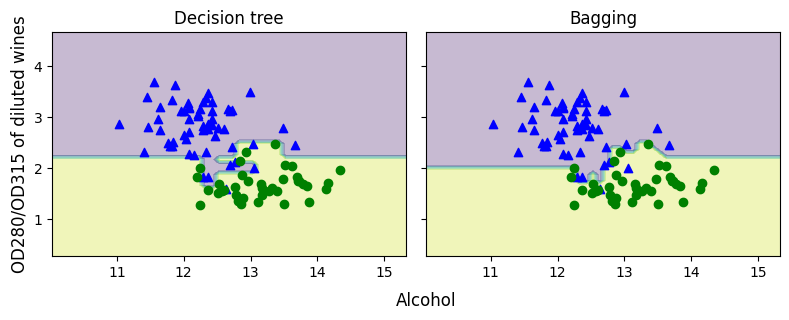

In [26]:
import numpy as np
import matplotlib.pyplot as plt


x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('OD280/OD315 of diluted wines', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='Alcohol',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

#plt.savefig('figures/07_08.png', dpi=300, bbox_inches='tight')
plt.show()

### Leverging weak learners via adaptive boosting

#### How boosting works

In [27]:
y = np.array([1, 1, 1, -1, -1, -1,  1,  1,  1, -1])
yhat = np.array([1, 1, 1, -1, -1, -1, -1, -1, -1, -1])
correct = (y == yhat)
weights = np.full(10, 0.1)
print(weights)

# coefficient 구하기(가중치된 에러율, espilon)
epsilon = np.mean(~correct)
print(epsilon)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.3


In [28]:
# coefficient 구하기(가중치된 에러율, espilon)
alpha_j = 0.5 * np.log((1-epsilon) / epsilon)
print(alpha_j)

0.42364893019360184


In [29]:
update_if_correct = 0.1 * np.exp(-alpha_j * 1 * 1)
print(update_if_correct)

0.06546536707079771


In [30]:
update_if_wrong_1 = 0.1 * np.exp(-alpha_j * 1 * -1)
print(update_if_wrong_1)

0.1527525231651947


In [31]:
update_if_wrong_2 = 0.1 * np.exp(-alpha_j * -1 * 1)
print(update_if_wrong_2)

0.1527525231651947


In [32]:
weights = np.where(correct == 1, update_if_correct, update_if_wrong_1)
print(weights)

[0.06546537 0.06546537 0.06546537 0.06546537 0.06546537 0.06546537
 0.15275252 0.15275252 0.15275252 0.06546537]


In [33]:
normalized_weights = weights / np.sum(weights)
print(normalized_weights)

[0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.16666667 0.16666667 0.16666667 0.07142857]


# Applying AdaBoost using scikit-learn

In [34]:
from sklearn.ensemble import AdaBoostClassifier


tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=1,
                              random_state=1)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500,
                         learning_rate=0.1,
                         random_state=1)

In [35]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'Decision tree train/test accuracies '
      f'{tree_train:.3f}/{tree_test:.3f}')

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print(f'AdaBoost train/test accuracies '
      f'{ada_train:.3f}/{ada_test:.3f}')

Decision tree train/test accuracies 0.916/0.875


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoost train/test accuracies 1.000/0.917


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


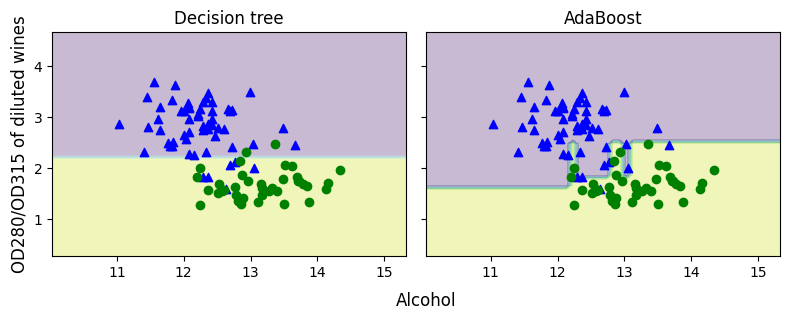

In [36]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('OD280/OD315 of diluted wines', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='Alcohol',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

# plt.savefig('figures/07_11.png', dpi=300, bbox_inches='tight')
plt.show()

## xgboost 실습

In [37]:
!pip install xgboost==1.5.1

In [38]:
import xgboost as xgb
xgb.__version__

/usr/local/lib/python3.10/dist-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


'1.5.1'

In [39]:
model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.01, max_depth=4, random_state=1, use_label_encoder=False)


gbm = model.fit(X_train, y_train)

y_train_pred = gbm.predict(X_train)
y_test_pred = gbm.predict(X_test)

gbm_train = accuracy_score(y_train, y_train_pred)
gbm_test = accuracy_score(y_test, y_test_pred)
print(f'XGboost train/test accuracies '
      f'{gbm_train:.3f}/{gbm_test:.3f}')

[05:43:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGboost train/test accuracies 0.968/0.917
